In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

In [2]:
os.getcwd()

'/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/notebooks'

In [3]:
local_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/energy_generation_data'

In [4]:
for path, dirs, files in os.walk(local_path):
    print(path)
    for f in files:
        print(f)

In [5]:
daily_data_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/Daily/energy_generation_data/df_deutschland.csv'
hourly_data_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv'

## Importing target

In [6]:
daily_df = pd.read_csv(daily_data_path)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df.set_index('Date', inplace=True)

daily_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
Date,,,,
2015-01-01,11.989583,1278.427083,75.531250,50hertz
2015-01-02,9.947917,2555.510417,17.677083,50hertz
2015-01-03,11.281250,2308.958333,27.354167,50hertz
2015-01-04,11.354167,2079.041667,49.750000,50hertz
2015-01-05,4.104167,1333.343750,20.187500,50hertz


In [229]:
hourly_df = pd.read_csv(hourly_data_path)

hourly_df['Date'] = pd.to_datetime(hourly_df['Date'])
hourly_df.set_index('Date', inplace=True)

hourly_df.tail()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
Date,,,,
2021-01-01 19:00:00,0.0,13.0,0.0,transnet_bw
2021-01-01 20:00:00,0.0,21.0,0.0,transnet_bw
2021-01-01 21:00:00,0.0,18.0,0.0,transnet_bw
2021-01-01 22:00:00,0.0,25.0,0.0,transnet_bw
2021-01-01 23:00:00,0.0,29.0,0.0,transnet_bw


In [10]:
hourly_de_df = hourly_df.groupby(hourly_df.index).sum()
hourly_de_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0
2015-01-01 03:00:00,519.0,8552.0,0.0
2015-01-01 04:00:00,522.0,8646.0,0.0


In [11]:
hourly_wind_de_df = pd.DataFrame(hourly_de_df.iloc[:,0] + hourly_de_df.iloc[:,1],columns=['Wind[MWh]'])
hourly_wind_de_df.head()

,Wind[MWh]
Date,
2015-01-01 00:00:00,8646.0
2015-01-01 01:00:00,8816.0
2015-01-01 02:00:00,9058.0
2015-01-01 03:00:00,9071.0
2015-01-01 04:00:00,9168.0


In [228]:
hourly_wind_de_df.tail()

,Wind[MWh]
Date,
2021-01-01 19:00:00,4845.0
2021-01-01 20:00:00,5028.0
2021-01-01 21:00:00,5204.0
2021-01-01 22:00:00,5681.0
2021-01-01 23:00:00,5333.0


## Importing features

In [12]:
feature_path = daily_data_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Features/DATAFRAMES'

hourly_windspeed_df = pd.read_csv(os.path.join(feature_path,'wind_hourly_clean.csv'))
hourly_airp_df = pd.read_csv(os.path.join(feature_path,'hourly_airp_df.csv'))

In [13]:
hourly_windspeed_df.head()

,Date,90,125,161,164,183,197,198,232,282,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
0,2015-01-01 00:00:00,2.1,0.7,0.9,5.1,11.3,3.2,1.6,1.1,0.7,...,3.9,0.8,4.9,3.2,4.4,3.0,0.5,1.2,1.0,2.2
1,2015-01-01 01:00:00,2.7,0.3,0.8,4.9,13.0,3.2,2.6,1.5,0.9,...,3.4,0.7,5.3,2.6,6.0,2.8,0.8,1.1,1.0,2.5
2,2015-01-01 02:00:00,2.5,0.8,1.3,3.9,12.8,3.2,3.2,1.7,0.9,...,3.8,1.3,4.8,2.3,5.7,3.1,0.5,1.8,1.2,2.6
3,2015-01-01 03:00:00,2.0,0.7,1.4,3.7,12.4,3.2,3.5,1.5,0.6,...,4.2,1.1,4.2,2.5,5.4,3.2,0.7,1.1,1.0,2.8
4,2015-01-01 04:00:00,1.1,0.9,1.7,4.2,12.2,3.2,3.4,1.7,1.0,...,4.4,0.9,4.1,1.8,6.1,3.6,0.8,0.9,1.4,2.8


In [14]:
hourly_airp_df.head()

,Date,44,71,73,78,91,96,102,125,131,...,13711,13713,13777,13965,15000,15207,15444,15555,19171,19172
0,2015-01-01 00:00:00,2.2,-3.7,-2.1,1.6,0.6,NaN,3.9,-9.6,1.1,...,1.9,1.1,4.2,-2.9,1.2,0.1,-2.2,NaN,NaN,NaN
1,2015-01-01 01:00:00,2.5,-3.8,-1.7,1.9,0.5,NaN,3.3,-8.8,1.3,...,1.7,0.9,3.7,-5.2,1.0,-0.8,-1.8,NaN,NaN,NaN
2,2015-01-01 02:00:00,2.3,-4.4,-1.8,1.6,0.3,NaN,3.7,-12.5,1.2,...,1.6,1.0,3.1,-5.3,1.1,-1.4,-2.3,NaN,NaN,NaN
3,2015-01-01 03:00:00,2.3,-3.2,-2.0,1.5,0.4,NaN,3.8,-11.0,1.4,...,1.5,0.9,1.8,-4.0,0.5,-1.7,-3.5,NaN,NaN,NaN
4,2015-01-01 04:00:00,1.9,-3.4,-1.7,1.5,0.4,NaN,3.8,-10.6,1.5,...,1.2,0.9,2.2,-3.6,0.9,-1.5,-1.6,NaN,NaN,NaN


In [15]:
hourly_windspeed_df.dtypes

Date      object
90       float64
125      float64
161      float64
164      float64
          ...   
15200    float64
15207    float64
15214    float64
15444    float64
1001     float64
Length: 261, dtype: object

In [16]:
hourly_airp_df.dtypes

Date      object
44       float64
71       float64
73       float64
78       float64
          ...   
15207    float64
15444    float64
15555    float64
19171    float64
19172    float64
Length: 516, dtype: object

In [17]:
hourly_windspeed_df['Date'] = pd.to_datetime(hourly_windspeed_df['Date'])

In [18]:
hourly_airp_df['Date'] = pd.to_datetime(hourly_airp_df['Date'])

In [19]:
hourly_windspeed_df.set_index('Date',inplace=True)

In [20]:
hourly_airp_df.set_index('Date',inplace=True)

# Exploring data

In [21]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210528 entries, 2015-01-01 00:00:00 to 2021-01-01 23:00:00
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Wind offshore[MWh]  210528 non-null  float64
 1   Wind onshore[MWh]   210528 non-null  float64
 2   Photovoltaics[MWh]  210528 non-null  float64
 3   region              210528 non-null  object 
dtypes: float64(3), object(1)
memory usage: 8.0+ MB


In [22]:
hourly_df.describe()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
count,210528.000000,210528.000000,210528.000000
mean,511.995312,2435.146745,1113.356722
std,1047.092125,2897.781013,1866.234916
min,0.000000,0.000000,0.000000
25%,0.000000,331.000000,0.000000
50%,0.000000,1256.000000,27.000000
75%,393.000000,3566.000000,1577.000000
max,10519.000000,29676.000000,12301.000000


In [23]:
hourly_df.isna().sum()

Wind offshore[MWh]    0
Wind onshore[MWh]     0
Photovoltaics[MWh]    0
region                0
dtype: int64

In [24]:
hourly_de_df = hourly_df.groupby(hourly_df.index).sum()
hourly_de_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0
2015-01-01 03:00:00,519.0,8552.0,0.0
2015-01-01 04:00:00,522.0,8646.0,0.0


In [25]:
hourly_wind_de_df.describe()

,Wind[MWh]
count,52632.000000
mean,11788.568228
std,9232.743682
min,0.000000
25%,4591.750000
50%,9229.000000
75%,16630.250000
max,77102.000000


## Plotting datasets

(array([2.618e+03, 5.136e+03, 5.533e+03, 4.910e+03, 4.347e+03, 3.831e+03,
        3.473e+03, 3.022e+03, 2.660e+03, 2.371e+03, 1.979e+03, 1.785e+03,
        1.529e+03, 1.282e+03, 1.210e+03, 1.059e+03, 9.680e+02, 8.780e+02,
        7.420e+02, 6.850e+02, 5.440e+02, 4.580e+02, 3.900e+02, 3.370e+02,
        3.110e+02, 1.980e+02, 1.870e+02, 1.000e+02, 5.300e+01, 9.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 5.000e+00,
        1.000e+00, 5.000e+00]),
 array([    0.  ,  1542.04,  3084.08,  4626.12,  6168.16,  7710.2 ,
         9252.24, 10794.28, 12336.32, 13878.36, 15420.4 , 16962.44,
        18504.48, 20046.52, 21588.56, 23130.6 , 24672.64, 26214.68,
        27756.72, 29298.76, 30840.8 , 32382.84, 33924.88, 35466.92,
        37008.96, 38551.  , 40093.04, 41635.08, 43177.12, 44719.16,
        46261.2 , 47803.24, 49345.28

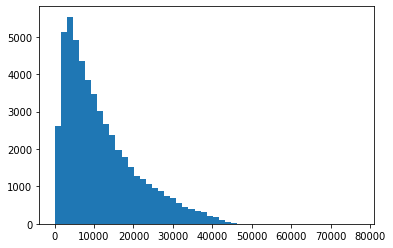

In [26]:
plt.hist(hourly_wind_de_df, bins = 50)

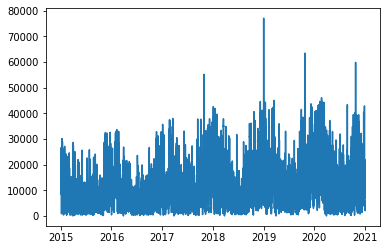

In [27]:
plt.plot(hourly_wind_de_df)

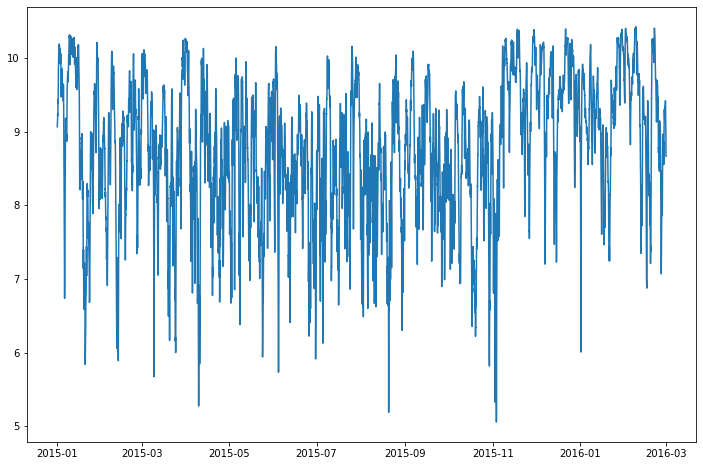

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(np.log(hourly_wind_de_df.loc[:dt.date(2016,3,1)]))

{'whiskers': [<matplotlib.lines.Line2D at 0x1486ff250>,
 'caps': [<matplotlib.lines.Line2D at 0x1486ff8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1486eddc0>],
 'medians': [<matplotlib.lines.Line2D at 0x1486fffd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1487083a0>],
 'means': []}

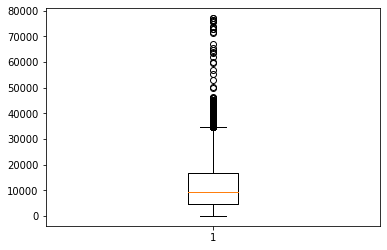

In [29]:
plt.boxplot(hourly_wind_de_df)

## Check for stationarity

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

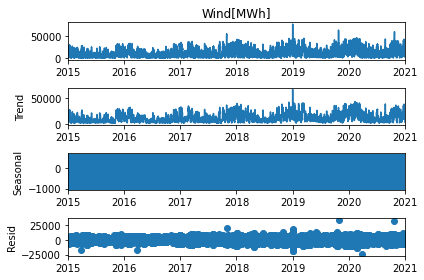

In [31]:
result_add = seasonal_decompose(hourly_wind_de_df['Wind[MWh]'], model='additive')
result_add.plot();

In [32]:
from statsmodels.tsa.stattools import adfuller

adfuller(hourly_wind_de_df['Wind[MWh]'])[1]

3.966579862447787e-29

In [33]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])

additive resid:  0.0


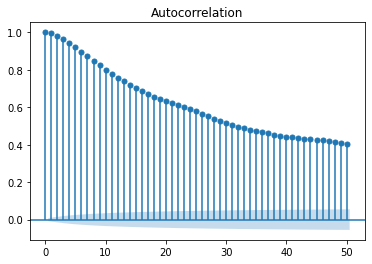

In [99]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(hourly_wind_de_df['Wind[MWh]'], lags=50)
plt.show()

In [100]:
y = hourly_wind_de_df['Wind[MWh]']

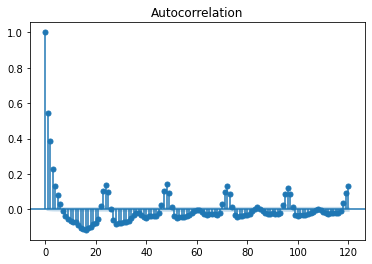

In [101]:
plot_acf(y.diff(1).dropna(), lags=120);

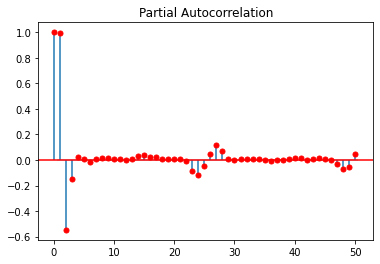

In [102]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(hourly_wind_de_df['Wind[MWh]'], lags=50, c='r')
plt.show()

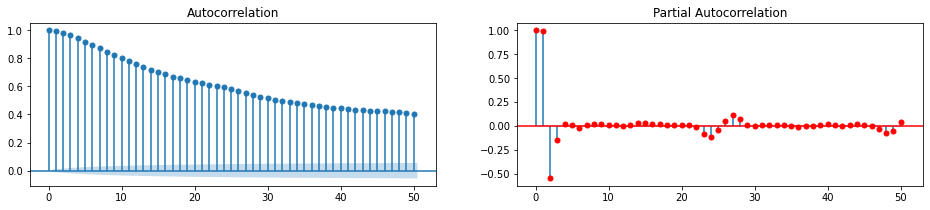

In [103]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(hourly_wind_de_df['Wind[MWh]'], lags=50, ax=axes[0]);
plot_pacf(hourly_wind_de_df['Wind[MWh]'], lags=50, ax=axes[1], color='r');

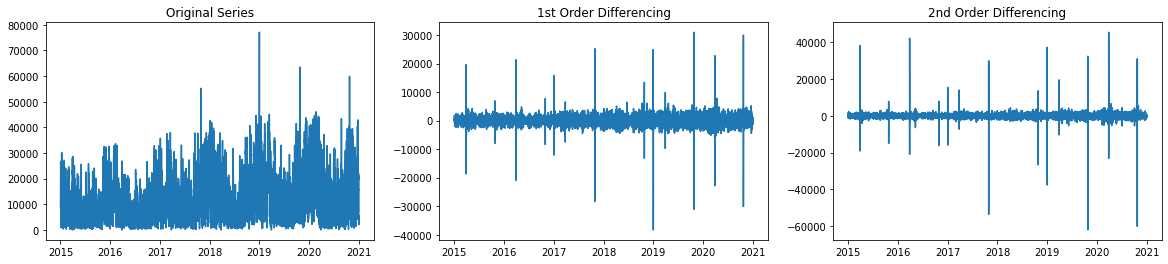

In [104]:
zero_diff = y
first_order_diff = y.diff(1)
second_order_diff = y.diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

## Building train/ test split

In [105]:
y_train = pd.DataFrame(y.loc[:dt.date(2016,1,1)])
y_test = pd.DataFrame(y.loc[dt.date(2016,1,1):dt.date(2016,3,1)])

y_train.shape

(8761, 1)

In [106]:
y_test.shape

(1441, 1)

# Time series models

## Basic ARIMA model

### Train and fit basic ARIMA model

In [107]:
import pmdarima as pm

smodel = pm.auto_arima(y_train,
                       start_p=1, max_p=2,
                       start_q=1, max_q=2,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=138144.609, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=141656.921, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=138245.059, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=139447.604, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=141654.921, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=138074.809, Time=1.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=138111.030, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=138055.897, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=138053.926, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=138409.231, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=138051.926, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=138407.231, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=138142.608, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=138053.897, Time=0.69 sec
 ARIM

In [85]:
from statsmodels.tsa.arima_model import ARIMA

arima_1 = ARIMA(y_train, order=(2,1,0)).fit()
arima_1.summary()

/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Wind[MWh]   No. Observations:                 8760
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -73496.492
Method:                       css-mle   S.D. of innovations           1065.345
Date:                Thu, 27 May 2021   AIC                         147000.984
Time:                        22:54:44   BIC                         147029.296
Sample:                    01-01-2019   HQIC                        147010.631
                         - 01-01-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.5312     26.082     -0.174      0.862     -55.651      46.588
ar.L1.D.Wind[MWh]     0.4074      0.011     38.589      0.000       0.387       0.428
ar.L2.D.Wind[MWh]     0.1562      0.011     14.799      0.000       0.136       0.177
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5423           +0.0000j            1.5423            0.0000
AR.2           -4.1498           +0.0000j            4.1498            0.5000
-----------------------------------------------------------------------------
"""

### Plot forecast of basic ARIMA model

In [92]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [108]:
forecast, std_err, confidence_int = arima_1.forecast(len(y_test), alpha=0.05)

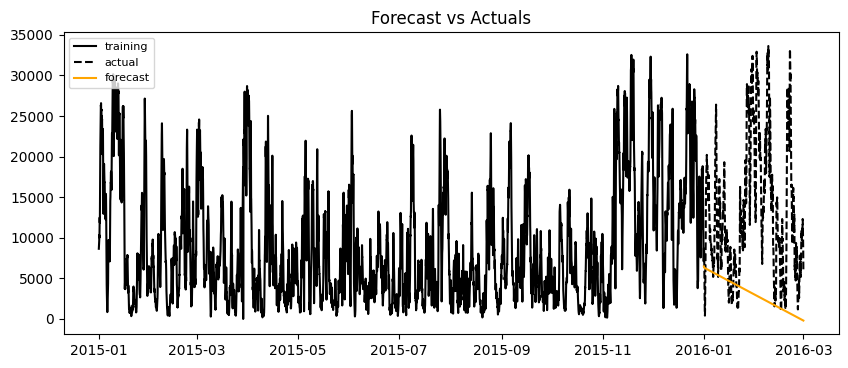

In [109]:
plot_forecast(forecast, y_train, y_test)

### Define loss functions

In [95]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [96]:
len(forecast)

1441

In [97]:
len(y_test)

1441

In [110]:
mean_absolute_percentage_error(forecast,y_test)

4067.604998530165

## Advanced SARIMAX model (incl. exogenous variables)

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [55]:
hourly_windspeed_df = hourly_windspeed_df.mean(axis=1)
hourly_windspeed_df.head()

Date
2015-01-01 00:00:00    3.320000
2015-01-01 01:00:00    3.306154
2015-01-01 02:00:00    3.313077
2015-01-01 03:00:00    3.280000
2015-01-01 04:00:00    3.300769
dtype: float64

In [56]:
hourly_airp_df = hourly_airp_df.mean(axis=1)
hourly_airp_df.head()

Date
2015-01-01 00:00:00    0.902414
2015-01-01 01:00:00    0.757948
2015-01-01 02:00:00    0.600604
2015-01-01 03:00:00    0.488330
2015-01-01 04:00:00    0.356942
dtype: float64

In [57]:
hourly_windspeed_df.shape

(55488,)

In [58]:
hourly_airp_df.shape

(55488,)

In [113]:
windspeed_train = pd.DataFrame(hourly_windspeed_df.loc[:dt.date(2016,1,1)])
windspeed_test = pd.DataFrame(hourly_windspeed_df.loc[dt.date(2016,1,1):dt.date(2016,3,1)])

windspeed_test.shape

(1441, 1)

In [115]:
airp_train = pd.DataFrame(hourly_airp_df.loc[:dt.date(2016,1,1)])
airp_test = pd.DataFrame(hourly_airp_df.loc[dt.date(2016,1,1):dt.date(2016,3,1)])

airp_test.shape

(1441, 1)

In [116]:
smodel_2 = pm.auto_arima(y_train, m=12, X=windspeed_train,
                       start_p=0, max_p=2,
                       start_q=0, max_q=5,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=10.74 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=140192.519, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=137740.708, Time=2.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=138492.560, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=140190.529, Time=0.85 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=137752.397, Time=0.28 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=137528.312, Time=6.37 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=29.57 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=12.54 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=139369.488, Time=21.61 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=137348.888, Time=9.33 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=137613.265, Time=2.79 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=44.96 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=16.49 sec
 ARIMA(2,1,1)(2,0,0)

In [117]:
smodel_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 8761
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 12)   Log Likelihood              -68658.713
Date:                             Thu, 27 May 2021   AIC                         137331.425
Time:                                     23:15:25   BIC                         137380.971
Sample:                                 01-01-2015   HQIC                        137348.307
                                      - 01-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0           1499.0325     45.957     32.618      0.000    1408.959    1589.106
ar.L1          0.5224      0.021     24.566      0.000       0.481       0.564
ma.L1         -0.1194      0.021     -5.817      0.000      -0.160      -0.079
ma.L2          0.1149      0.007     15.603      0.000       0.100       0.129
ar.S.L12      -0.0298      0.009     -3.328      0.001      -0.047      -0.012
ar.S.L24       0.1711      0.003     64.417      0.000       0.166       0.176
sigma2      3.874e+05    877.337    441.569      0.000    3.86e+05    3.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         109932244.04
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             5.83
Prob(H) (two-sided):                  0.00   Kurtosis:                       551.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
windspeed_test.head()

,0
Date,
2016-01-01 00:00:00,2.448077
2016-01-01 01:00:00,2.442692
2016-01-01 02:00:00,2.480000
2016-01-01 03:00:00,2.453846
2016-01-01 04:00:00,2.467692


In [119]:
y_test.head()

,Wind[MWh]
Date,
2016-01-01 00:00:00,8650.0
2016-01-01 01:00:00,8580.0
2016-01-01 02:00:00,8544.0
2016-01-01 03:00:00,8446.0
2016-01-01 04:00:00,8298.0


In [120]:
y_train.shape

(8761, 1)

In [121]:
windspeed_train.shape

(8761, 1)

In [122]:
y_test.shape

(1441, 1)

In [123]:
windspeed_test.shape

(1441, 1)

In [129]:
sarimax = SARIMAX(endog=y_train,exog=windspeed_train.to_numpy().reshape(-1,1),order=(1,1,2),seasonal=(2,0,0,12),alpha=0.05).fit()

/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [130]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Wind[MWh]   No. Observations:                 8761
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -68784.682
Date:                Thu, 27 May 2021   AIC                         137579.365
Time:                        23:16:17   BIC                         137614.755
Sample:                    01-01-2015   HQIC                        137591.423
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1499.0322     42.719     35.091      0.000    1415.305    1582.760
ar.L1          0.4787      0.020     23.559      0.000       0.439       0.519
ma.L1         -0.0403      0.020     -2.053      0.040      -0.079      -0.002
ma.L2          0.1369      0.007     18.989      0.000       0.123       0.151
sigma2      3.874e+05    839.156    461.663      0.000    3.86e+05    3.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         114407589.74
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             6.20
Prob(H) (two-sided):                  0.00   Kurtosis:                       562.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
forecast_2 = sarimax.forecast(len(y_test), exog=windspeed_test, alpha=0.05)

In [145]:
forecast_2.shape

(1441,)

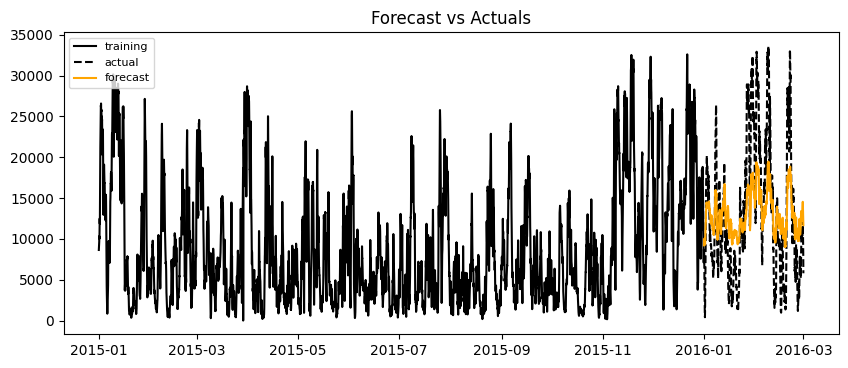

In [132]:
plot_forecast(forecast_2, y_train, y_test)

In [133]:
mean_absolute_percentage_error(forecast_2,y_test)

56.17283581924014

# Baseline models

## Baseline model (previous hour)

In [148]:
y_pred = y_test.shift(1)
y_pred

,Wind[MWh]
Date,
2016-01-01 00:00:00,NaN
2016-01-01 01:00:00,8650.0
2016-01-01 02:00:00,8580.0
2016-01-01 03:00:00,8544.0
2016-01-01 04:00:00,8446.0
...,...
2016-02-29 20:00:00,10045.0
2016-02-29 21:00:00,9631.0
2016-02-29 22:00:00,9160.0


In [151]:
y_pred = y_pred.squeeze()

In [152]:
y_test.shape

(1441, 1)

In [153]:
y_pred.isnull().sum()

1

In [159]:
y_pred[y_pred.isna()] = y_pred.mean()

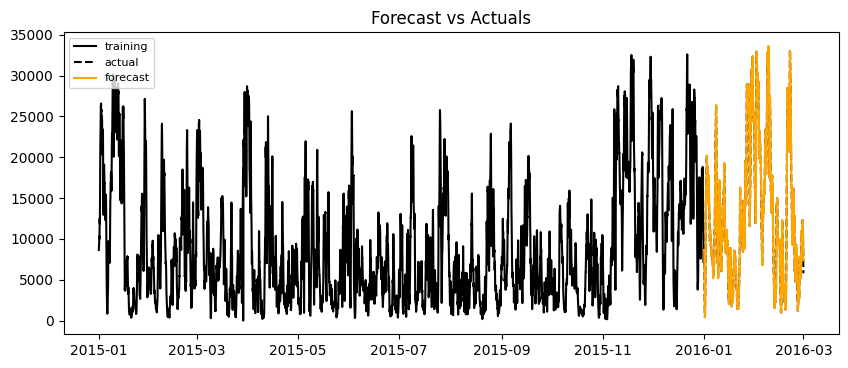

In [155]:
plot_forecast(y_pred, y_train, y_test)

In [160]:
mean_absolute_percentage_error(y_pred,y_test)

136.54027446366553

In [157]:
y_pred

Date
2016-01-01 00:00:00        NaN
2016-01-01 01:00:00     8650.0
2016-01-01 02:00:00     8580.0
2016-01-01 03:00:00     8544.0
2016-01-01 04:00:00     8446.0
                        ...   
2016-02-29 20:00:00    10045.0
2016-02-29 21:00:00     9631.0
2016-02-29 22:00:00     9160.0
2016-02-29 23:00:00     8320.0
2016-03-01 00:00:00     7371.0
Name: Wind[MWh], Length: 1441, dtype: float64

In [158]:
y_test

,Wind[MWh]
Date,
2016-01-01 00:00:00,8650.0
2016-01-01 01:00:00,8580.0
2016-01-01 02:00:00,8544.0
2016-01-01 03:00:00,8446.0
2016-01-01 04:00:00,8298.0
...,...
2016-02-29 20:00:00,9631.0
2016-02-29 21:00:00,9160.0
2016-02-29 22:00:00,8320.0


## Baseline model (previous day)

In [162]:
y_pred2 = y_test.shift(24)
y_pred2

,Wind[MWh]
Date,
2016-01-01 00:00:00,NaN
2016-01-01 01:00:00,NaN
2016-01-01 02:00:00,NaN
2016-01-01 03:00:00,NaN
2016-01-01 04:00:00,NaN
...,...
2016-02-29 20:00:00,10920.0
2016-02-29 21:00:00,10795.0
2016-02-29 22:00:00,10607.0


In [163]:
y_pred2 = y_pred2.squeeze()

In [164]:
y_pred2[y_pred2.isna()] = y_pred2.mean()

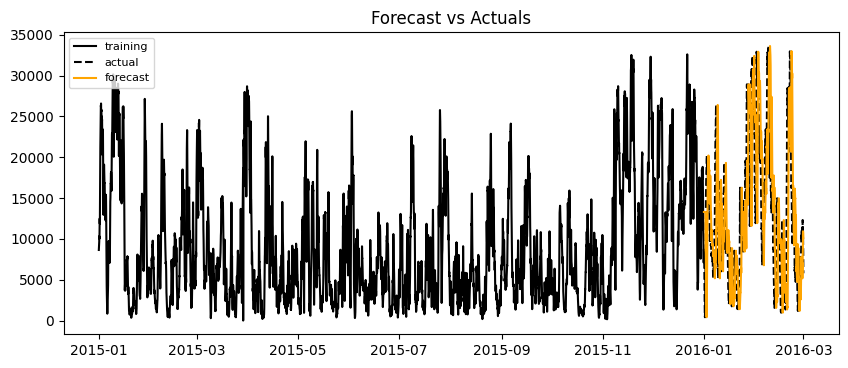

In [166]:
plot_forecast(y_pred2, y_train, y_test)

In [165]:
mean_absolute_percentage_error(y_pred2,y_test)

136.30381805203976

# Optimize predicting timeframe

In [174]:
y_test_1 = pd.DataFrame(y.loc[dt.date(2016,1,1):dt.date(2016,1,2)])
y_test_7 = pd.DataFrame(y.loc[dt.date(2016,1,1):dt.date(2016,1,8)])
y_test_14 = pd.DataFrame(y.loc[dt.date(2016,1,1):dt.date(2016,1,15)])
y_test_30 = pd.DataFrame(y.loc[dt.date(2016,1,1):dt.date(2016,2,1)])

In [175]:
windspeed_test_1 = pd.DataFrame(hourly_windspeed_df.loc[dt.date(2016,1,1):dt.date(2016,1,2)])
windspeed_test_7 = pd.DataFrame(hourly_windspeed_df.loc[dt.date(2016,1,1):dt.date(2016,1,8)])
windspeed_test_14 = pd.DataFrame(hourly_windspeed_df.loc[dt.date(2016,1,1):dt.date(2016,1,15)])
windspeed_test_30 = pd.DataFrame(hourly_windspeed_df.loc[dt.date(2016,1,1):dt.date(2016,2,1)])

In [177]:
forecast_test_1 = sarimax.forecast(len(y_test_1), exog=windspeed_test_1, alpha=0.05)
forecast_test_7 = sarimax.forecast(len(y_test_7), exog=windspeed_test_7, alpha=0.05)
forecast_test_14 = sarimax.forecast(len(y_test_14), exog=windspeed_test_14, alpha=0.05)
forecast_test_30 = sarimax.forecast(len(y_test_30), exog=windspeed_test_30, alpha=0.05)

In [183]:
mean_absolute_percentage_error(forecast_test_1,y_test_1)

53.39213047188077

In [184]:
mean_absolute_percentage_error(forecast_test_7,y_test_7)

39.6191729818461

In [185]:
mean_absolute_percentage_error(forecast_test_14,y_test_14)

35.25798289458658

In [186]:
mean_absolute_percentage_error(forecast_test_30,y_test_30)

51.44627442748059

In [187]:
mean_absolute_percentage_error(forecast_2,y_test)

56.17283581924014

In [253]:
def find_best_timeframe(start_date,max_days, model):
    best_score = 1000000
    for days in range(1,max_days+1):
        y_test = pd.DataFrame(y.loc[start_date:start_date+dt.timedelta(days)])
        windspeed_test = pd.DataFrame(hourly_windspeed_df.loc[start_date:start_date+dt.timedelta(days)])
        forecast_test = model.forecast(len(y_test), exog=windspeed_test, alpha=0.05)
        mape = mean_absolute_percentage_error(forecast_test,y_test)
        print(f'{days}: {mape}')
        if mape < best_score:
            best_score = mape
            best_timeframe = days
    return best_timeframe, best_score

In [218]:
find_best_timeframe(60,sarimax)

1: 53.39213047188077
2: 55.91737480996367
3: 48.389799986087695
4: 39.931796470851395
5: 38.11698296670587
6: 39.891794531602045
7: 39.6191729818461
8: 42.392524478410294
9: 41.82442169879377
10: 39.746341792152364
11: 39.06640697129413
12: 37.05912606677703
13: 36.38196236533504
14: 35.25798289458658
15: 36.134958812085934
16: 37.203478812800626
17: 38.91142861310197
18: 40.733227481393236
19: 40.787626979852796
20: 41.756414108950075
21: 43.805096600333684
22: 43.83430084459165
23: 42.44949397152849
24: 41.525431547110344
25: 40.738733260411166
26: 41.900433618519564
27: 45.219613885419356
28: 45.81644502786265
29: 48.466381977149865
30: 51.09365422776149
31: 51.44627442748059
32: 52.645452360467814
33: 54.85555006634725
34: 55.305052880864956
35: 54.552888711175875
36: 53.69337963473575
37: 53.204091448261984
38: 53.503547086871215
39: 55.62056479377717
40: 56.45879419394966
41: 55.701071554388925
42: 55.073425236921416
43: 55.80312161220286
44: 55.888156507706846
45: 55.08627960125

(14, 35.25798289458658)

# Validate SARIMAX model with different timeframe

In [236]:
def train_test_split(start_date,train_size,test_size):
    y_train = pd.DataFrame(y.loc[start_date:start_date+dt.timedelta(train_size)])
    y_test = pd.DataFrame(y.loc[start_date+dt.timedelta(train_size):start_date+dt.timedelta(train_size+test_size)])    
    
    
    windspeed_train = pd.DataFrame(hourly_windspeed_df.loc[start_date:start_date+dt.timedelta(train_size)])
    windspeed_test = pd.DataFrame(hourly_windspeed_df.loc[start_date+dt.timedelta(train_size):start_date+dt.timedelta(train_size+test_size)])  
    
    return y_train, y_test, windspeed_train, windspeed_test

In [238]:
y_train, y_test, windspeed_train, windspeed_test = train_test_split(dt.date(2020,1,1)-dt.timedelta(14),366,14)

In [249]:
y_train.head()

,Wind[MWh]
Date,
2019-12-18 00:00:00,32930.0
2019-12-18 01:00:00,32918.0
2019-12-18 02:00:00,32564.0
2019-12-18 03:00:00,30266.0
2019-12-18 04:00:00,28307.0


In [232]:
y_train.tail()

,Wind[MWh]
Date,
2020-12-17 20:00:00,22819.0
2020-12-17 21:00:00,22412.0
2020-12-17 22:00:00,22157.0
2020-12-17 23:00:00,21789.0
2020-12-18 00:00:00,21586.0


In [250]:
y_test.head()

,Wind[MWh]
Date,
2020-12-18 00:00:00,21586.0
2020-12-18 01:00:00,20672.0
2020-12-18 02:00:00,19967.0
2020-12-18 03:00:00,19601.0
2020-12-18 04:00:00,19105.0


In [234]:
y_test.tail()

,Wind[MWh]
Date,
2020-12-31 20:00:00,7962.0
2020-12-31 21:00:00,7029.0
2020-12-31 22:00:00,5949.0
2020-12-31 23:00:00,5085.0
2021-01-01 00:00:00,4351.0


In [239]:
smodel = pm.auto_arima(y_train, m=12, X=windspeed_train,
                       start_p=0, max_p=2,
                       start_q=0, max_q=5,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=15.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=149683.362, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=147627.164, Time=2.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=148250.237, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=220663.124, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=147640.324, Time=0.50 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=147408.257, Time=7.90 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=31.09 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=11.15 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=149162.959, Time=6.03 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=147152.906, Time=9.17 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=147443.426, Time=2.91 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=41.94 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=7.68 sec
 ARIMA(2,1,1)(2,0,0)[1

In [240]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8785
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 12)   Log Likelihood              -73569.460
Date:                            Sat, 29 May 2021   AIC                         147150.920
Time:                                    12:56:55   BIC                         147193.404
Sample:                                12-18-2019   HQIC                        147165.394
                                     - 12-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0           1579.7099     77.537     20.374      0.000    1427.739    1731.680
ar.L1          0.3496      0.002    184.955      0.000       0.346       0.353
ar.L2          0.1715      0.004     44.960      0.000       0.164       0.179
ar.S.L12      -0.0227      0.009     -2.430      0.015      -0.041      -0.004
ar.S.L24       0.1841      0.003     67.511      0.000       0.179       0.189
sigma2      1.135e+06   2537.663    447.362      0.000    1.13e+06    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):          71904793.92
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -2.43
Prob(H) (two-sided):                  0.01   Kurtosis:                       446.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [241]:
sarimax_2 = SARIMAX(endog=y_train,exog=windspeed_train.to_numpy().reshape(-1,1),order=(2,1,0),seasonal=(2,0,0,12),alpha=0.05).fit()

/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [251]:
sarimax_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Wind[MWh]   No. Observations:                 8785
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -73719.045
Date:                Sat, 29 May 2021   AIC                         147446.090
Time:                        13:14:22   BIC                         147474.413
Sample:                    12-18-2019   HQIC                        147455.739
                         - 12-18-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1579.7098     66.970     23.588      0.000    1448.451    1710.969
ar.L1          0.3830      0.002    233.815      0.000       0.380       0.386
ar.L2          0.1467      0.003     42.270      0.000       0.140       0.153
sigma2      1.135e+06   2451.955    463.000      0.000    1.13e+06    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.83   Jarque-Bera (JB):          72437872.94
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -2.54
Prob(H) (two-sided):                  0.01   Kurtosis:                       447.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [242]:
sarimax = SARIMAX(endog=y_train,exog=windspeed_train.to_numpy().reshape(-1,1),order=(1,1,2),seasonal=(2,0,0,12),alpha=0.05).fit()

/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [243]:
forecast_2 = sarimax_2.forecast(len(y_test), exog=windspeed_test, alpha=0.05)

In [244]:
forecast_3 = sarimax.forecast(len(y_test), exog=windspeed_test, alpha=0.05)

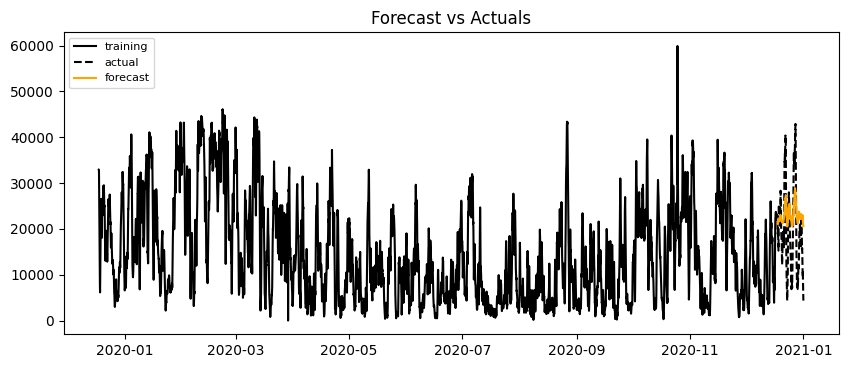

In [245]:
plot_forecast(forecast_2, y_train, y_test)

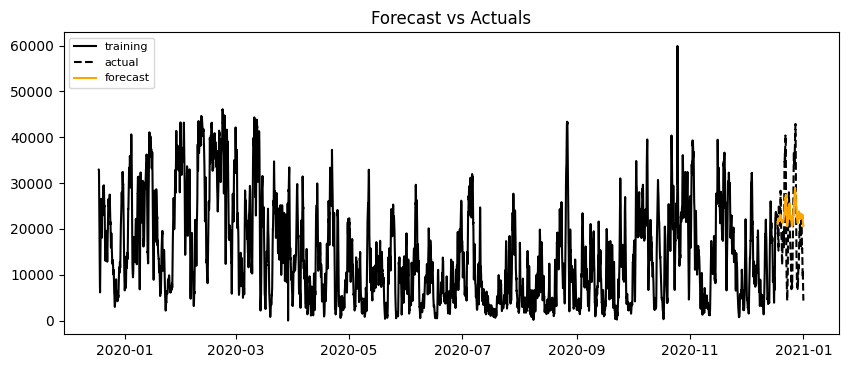

In [246]:
plot_forecast(forecast_3, y_train, y_test)

In [254]:
find_best_timeframe(dt.date(2020,1,1)-dt.timedelta(14),60,sarimax_2)

1: 40.009409053891666
2: 26.277489916089298
3: 24.751696314250683
4: 24.275472271013633
5: 23.69233370665946
6: 21.8640884438941
7: 21.166655062640512
8: 24.285482816797444
9: 30.045999570838756
10: 34.32779874371211
11: 37.59062928299415
12: 37.32476200717695
13: 36.47906683178883
14: 36.52691396888684
15: 37.99613846953753
16: 37.410876496858165
17: 37.9593288502957
18: 38.660918320101075
19: 38.79356054999621
20: 38.166652640196006
21: 37.2915910002639
22: 37.257171992264986
23: 37.096927905426455
24: 36.29619856857795
25: 35.72419022328649
26: 36.0633244835575
27: 35.80049726349067
28: 36.990124796982535
29: 37.54046993470951
30: 37.25675447453085
31: 36.603104718379164
32: 36.04545333870838
33: 36.49253029595051
34: 37.15946424490261
35: 37.03617741208624
36: 37.60828318069391
37: 38.76055892662603
38: 39.390083353877465
39: 40.16118970084595
40: 40.54234772619573
41: 39.799759781181834
42: 40.100279001837855
43: 40.49712269615999
44: 40.83310337029988
45: 41.319171722409855
46: 4

(7, 21.166655062640512)

In [256]:
mean_absolute_percentage_error(forecast_2,y_test)

36.14153859048661

In [257]:
find_best_timeframe(dt.date(2020,1,1)-dt.timedelta(14),60,sarimax)

1: 40.00680646998818
2: 26.203423506987654
3: 24.614579080390282
4: 24.19734381386299
5: 23.667792943356154
6: 21.809943287559193
7: 21.144333504219816
8: 24.28249395698758
9: 30.045247843465795
10: 34.33090979228033
11: 37.597747876622634
12: 37.340921648017996
13: 36.470842564352246
14: 36.51804067898418
15: 37.99354749719202
16: 37.41176647728044
17: 37.94078501430523
18: 38.628467064912606
19: 38.76969496937099
20: 38.15102915975421
21: 37.27754359880102
22: 37.23821981266883
23: 37.07296761881343
24: 36.26676383215039
25: 35.695102993969726
26: 36.0226149581948
27: 35.762123321536855
28: 36.9397179778769
29: 37.48000563828302
30: 37.19756753701427
31: 36.54188783402039
32: 35.985986739286716
33: 36.43764777566974
34: 37.108447407111015
35: 36.99099564166095
36: 37.56678248317395
37: 38.72080479596885
38: 39.35334466424007
39: 40.12671225385055
40: 40.511024609644515
41: 39.767660120531914
42: 40.06114896407125
43: 40.450868372298004
44: 40.78004515901202
45: 41.25943455661577
46: 

(7, 21.144333504219816)

In [258]:
mean_absolute_percentage_error(forecast_3,y_test)

36.15269530629562

# Cross-validate model with timeseries split

In [259]:
from sklearn.model_selection import TimeSeriesSplit

In [260]:
n_splits = 5

tscv = TimeSeriesSplit(n_splits)

for train_index, test_index in tscv.split(y):
    smodel = pm.auto_arima(y[train_index],
                       start_p=0, max_p=2,
                       start_q=0, max_q=2,
                       error_action='ignore',
                       suppress_warnings=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=141833.593, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=138413.321, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=139619.707, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=141831.602, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=138278.536, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=138242.282, Time=1.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=138312.267, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=138223.514, Time=1.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=138221.547, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=138578.717, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=138219.556, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=138576.724, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=138310.277, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=138221.523, Time=0.93 sec
 ARIM

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import itertools
import warnings

warnings.filterwarnings('ignore')


p = d = q = [0,1,2]

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

grid = itertools.product(p, d, q)
orders = []
seasonals = []
r2s = []
aics = []
fold_idxs = []

for (p,d,q) in grid:
    for param_seasonal in seasonal_pdq:
        order = (p,d,q)
        seasonal = param_seasonal
        folds = TimeSeriesSplit(n_splits=3)
        
        for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
            fold_idxs.append(fold_idx)
            y_train = y[train_idx]
            y_test = y[test_idx]
            model = SARIMAX(y_train, 
                            order=order,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            # y_pred = model.forecast(len(y_test))[0] for unknown reason this crash
            # r2s.append(r2_score(y_pred, y_true))
            orders.append(order)
            seasonals.append(seasonal)
            aics.append(results.aic)       
        
df = pd.DataFrame(list(zip(fold_idxs, orders, seasonals, aics)),#, r2s)), 
                   columns =['Fold', '(p,d,q)', 'seasonals','AIC'])#, 'R2'])

In [ ]:
df.head()

In [262]:
df.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].sort_values()

(p,d,q)
(2, 1, 2)    422186.890835
(1, 1, 2)    422378.656133
(2, 2, 2)    422404.823900
(2, 1, 1)    422409.560057
(2, 2, 1)    422443.496893
(2, 1, 0)    422448.052632
(1, 2, 2)    422516.786095
(1, 1, 1)    422521.007782
(1, 2, 1)    422852.652480
(1, 1, 0)    422856.988237
(0, 1, 2)    423511.110256
(0, 2, 2)    425482.901113
(0, 2, 1)    425886.688244
(0, 1, 1)    426185.309629
(2, 2, 0)    426299.599622
(1, 2, 0)    426611.156774
(0, 2, 0)    429406.666440
(0, 1, 0)    432716.060641
Name: AIC, dtype: float64

In [266]:
df.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].min()

422186.89083512314

In [265]:
for train_index, test_index in tscv.split(y):
    print('train_index', train_index.shape)
    print('test_index', test_index.shape)

train_index (8772,)
test_index (8772,)
train_index (17544,)
test_index (8772,)
train_index (26316,)
test_index (8772,)
train_index (35088,)
test_index (8772,)
train_index (43860,)
test_index (8772,)


In [ ]:
model = pm.auto_arima(df_train['Sales'],
                      m=12, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())